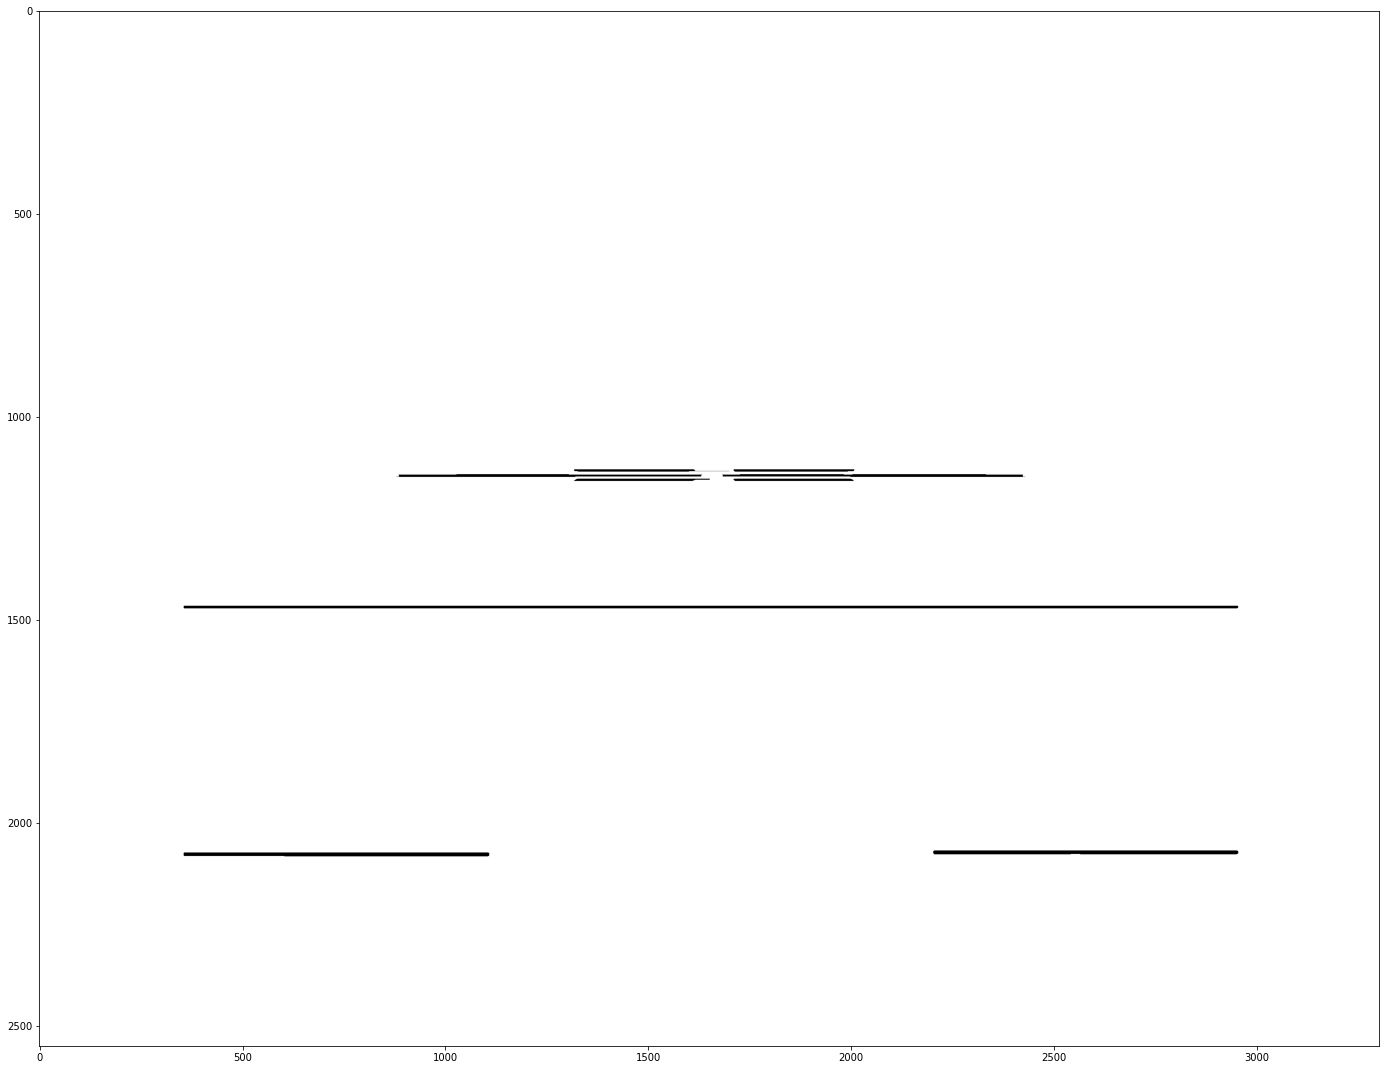

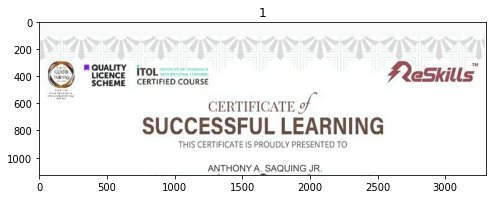

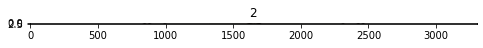

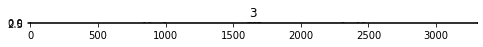

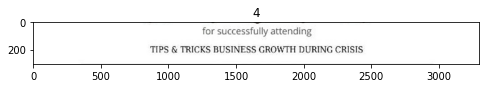

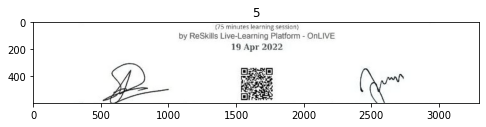

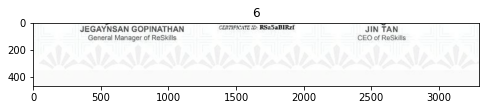

In [1]:
from IPython.display import Image
from matplotlib import pyplot as plt
import pandas as pd, numpy as np
pd.options.display.float_format = ':,.2f'.format

from google.cloud import vision
import io

import warnings
warnings.simplefilter("ignore")

import os, cv2
os.chdir(r'C:\Users\Lenovo\Desktop\ExpressWrite\uploads')

fileList = [x for x in os.listdir() if 'jpg' in x.lower()]
fileList[:5]

Image(filename = fileList[2], width = 300)

img = fileList[2]

def findHorizontalLines(img):
    img = cv2.imread(img) 
    
    #convert image to greyscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # set threshold to remove background noise
    thresh = cv2.threshold(gray,30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    
    # define rectangle structure (line) to look for: width 100, hight 1. This is a 
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (200,1))
    
    # Find horizontal lines
    lineLocations = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    
    return lineLocations

lineLocations = findHorizontalLines(img)
plt.figure(figsize=(24,24))
plt.imshow(lineLocations, cmap='Greys')

df_lineLocations = pd.DataFrame(lineLocations.sum(axis=1)).reset_index()
df_lineLocations.columns = ['rowLoc', 'LineLength']
df_lineLocations[df_lineLocations['LineLength'] > 0]

df_lineLocations['line'] = 0
df_lineLocations['line'][df_lineLocations['LineLength'] > 100] = 1

df_lineLocations['cumSum'] = df_lineLocations['line'].cumsum()

df_lineLocations.head()

import pandasql as ps

query = '''
select row_number() over (order by cumSum) as SegmentOrder
, min(rowLoc) as SegmentStart
, max(rowLoc) - min(rowLoc) as Height
from df_lineLocations
where line = 0
--and CumSum !=0
group by cumSum
'''

df_SegmentLocations  = ps.sqldf(query, locals())
df_SegmentLocations

def pageSegmentation1(img, w, df_SegmentLocations):
    img = cv2.imread(img) 
    im2 = img.copy()
    segments = []

    for i in range(len(df_SegmentLocations)):
        y = df_SegmentLocations['SegmentStart'][i]
        h = df_SegmentLocations['Height'][i]

        cropped = im2[y:y + h, 0:w] 
        segments.append(cropped)
        plt.figure(figsize=(8,8))
        plt.imshow(cropped)
        plt.title(str(i+1))        

    return segments

img = fileList[2]
w = lineLocations.shape[1]
segments = pageSegmentation1(img, w, df_SegmentLocations)

import re
import cv2
import pytesseract
from pytesseract import Output

# tell pytesseract where the engine is installed
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'


def extractTextFromImg(segment):
    text = pytesseract.image_to_string(segment, lang='eng')         
    text = text.encode("gbk", 'ignore').decode("gbk", "ignore")
        
    return text

segment = segments[1]
text = extractTextFromImg(segment)
print(text)

In [3]:
import re
import cv2
import pytesseract
from pytesseract import Output

# tell pytesseract where the engine is installed
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'


def extractTextFromImg(segment):
    text = pytesseract.image_to_string(segment, lang='eng')         
    text = text.encode("gbk", 'ignore').decode("gbk", "ignore")
        
    return text

segment = segments[1]
text = extractTextFromImg(segment)
print(text)